# 546 (Optimization for Learning and Control) hw2

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file) and upload a .pdf of the article to Canvas alongside your homework submission.  **Your submission must be a product of your own work.**

In [3]:
import numpy as np
import math
import numpy.linalg as la
import scipy.linalg as sla
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Markov decision process (MDP)

Let $(X,U,P,c)$ be an MDP, i.e.

* $X$ is a finite set of $n$ *states*
* $U$ is a finite set of $m$ *actions*
* $P:X\times U\rightarrow \Delta(X)$ is transition probability
* $c:X\times U\rightarrow \mathbb{R}$ is cost

where $\Delta(S) = \{p\in[0,1]^S : \sum_{s\in S} p(s) = 1\}$ is the set of probability distributions over the finite set $S$.

a. *Implement an algorithm that generates a random MDP given finite sets $X$ and $U$ (i.e. let $N = |X|$, $M = |U|$ be parameters that are easy to vary, and generate $P$ and $c$ randomly).*

In [4]:
def draw_from_dis(dis_list):
    s = np.random.choice(dis_list,p=dis_list)
    s = np.argmax(dis_list == s)
    return s
    
class MDP_generator:
    def __init__(self, X, U, get_P, get_c, p_0):
        # state set
        self.X = X
        # action set
        self.U = U
        # function takes current state and action return a distribution of next state (list of probabilities)
        self.P = get_P
        # cost function takes in current state and action
        self.c = get_c
        # current state(initialized randomly)
        s = draw_from_dis(p_0)
        self.x = s
        
    def step(self, action):
        # action -- index over action list
        dis_list = self.P(self.x, action)
        #print dis_list
        s = draw_from_dis(dis_list)
        old_x = self.x
        self.x = s
        return self.x, self.c(old_x, action)

b. *Implement an algorithm that simulates an MDP (i.e. write a function that inputs transition probabilities $P$, cost $c$, initial state distribution $p_0$, policy $\pi:X\rightarrow\Delta(U)$, and time horizon $t$ and returns the state distribution $p_t$).*

In [5]:
def MDP_sim(X, U, get_P, get_c, p_0, get_pi, total_steps):
    env = MDP_generator(X, U, get_P, get_c, p_0)
    cost_history = []
    total_cost = 0
    #print 'init system state: ' + str(env.x)
    for i in range(total_steps):
        action_dis = get_pi(env.x)
        action = draw_from_dis(action_dis)
        next_x, cost = env.step(action)
        cost_history.append(cost)
        total_cost = total_cost + cost
        #print 'state: ' + str(next_x) + ' cost: ' + str(cost)
    #print 'total cost: ' + str(total_cost)
    return env.x, total_cost, cost_history

c. *Test your algorithm from (b.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

Let us now consider the problem of minimizing the infinite-horizon discounted cost
$$J = \sum_{t=0}^\infty \gamma^t c_t,$$
where $\gamma\in(0,1)$ is a *discount factor* and $c_t = c(x_t,u_t)$ is the cost at time $t$.

Any policy $\pi : X\rightarrow\Delta(U)$ has an associated *value* $v^\pi : X\rightarrow\mathbb{R}$ defined by
$$\forall x\in X : v^\pi(x) = E[J \mid x = x_0]$$
that satisfies the *Bellman equation*
$$\forall x\in X : v^\pi(x) = \sum_{u\in U}\pi(u|x)\sum_{x^+\in X} P(x^+|x,u)\left[c(x,u) + \gamma \cdot v^\pi(x^+)\right].$$

In [6]:
gamma = 0.99
'''
def discount_costs(c_history):
    # discounted costs
    discounted_c = np.zeros_like(c_history)
    running_add = 0
    for t in reversed(range(0, len(c_history))):
        running_add = running_add * gamma + c_history[t]
        discounted_c[t] = running_add
    return discounted_c
'''

def discount_costs(c_history, gamma):
    total_cost = 0
    for t in range(0,len(c_history)):
        total_cost = total_cost + gamma**t * c_history[t]
        
    return total_cost

In [5]:
# X, U, P, c, p_0
X = 3 # 3 states
U = 3 # action for every possible system state

# X x U
P = np.array([[[0.1, 0.3, 0.6],[0.3, 0.4, 0.3],[0.0, 0.8, 0.2]],
              [[0.5, 0.0, 0.5],[0.0, 0.0, 1.0],[0.6, 0.1, 0.3]],
              [[0.2, 0.2, 0.6],[0.7, 0.1, 0.2],[0.4, 0.6, 0.0]]])

C = np.array([[4,3,5],[5,6,2],[7,2,1]])

pi = np.array([[0.2, 0.3, 0.5],[0.4, 0.5, 0.1],[0.3, 0.1, 0.6]])

def get_P(s, a):
    return P[s,a]
        
def get_c(s, a):
    #return C[s,a]
    return pi[s,0]*C[s,0] + pi[s,1]*C[s,1] + pi[s,2]*C[s,2]
        
def get_pi(s):
    return pi[s,:]
        
p_0 = [0.3, 0.2, 0.5]

total_steps = 1000

gamma = 0.99
test = 0
iteration = 100
for i in range(iteration):
    #print 'runing: ' + str(i)
    fx,fc,his_ = MDP_sim(X, U, get_P, get_c, p_0, get_pi, total_steps)
    test = test + discount_costs(his_, gamma)

print test/iteration

411.0580945411905


d. *Noting that $v^\pi$ appears linearly in this Bellman equation, implement a *policy evaluation* algorithm that computes $v^\pi$ using linear algebra (i.e. determing $L$ and $b$ such that $L v^\pi = b$ and use this equation to solve for $v^\pi$).*

For value $v^{\pi} = (I- \gamma \pi P)^{-1} \pi P C$

In [6]:
def get_V(x, pi, P, C, gamma):
    #v_list = np.dot(np.linalg.inv(np.identity(3) - gamma*np.dot(pi, P[x,:])), C)
    v_list = np.dot(np.linalg.inv(np.identity(3) - gamma * np.dot(pi, P[x,:])), np.dot(pi, np.dot(P[x,:],C)))
    return sum(v_list)/3

e. *Test your policy evaluation algorithm from (d.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

In [37]:
v_list = get_V(2, pi, P, C, 0.99)
print sum(v_list)/3

395.0632595031366


As it shown above, the calulated value for $v^{\pi}$ for initial state 2 is 395 and our simulation value is 410 which is fairly close. 

f. *Using your policy evaluation algorithm from (d.), implement *value iteration* and *policy iteration* algorithms.*

In [79]:
class value_iteration:
    def __init__(self, env, theta=0.0001, gamma=0.99):
        self.env= env
        self.xc = env.X # state counts
        self.uc = env.U # action counts
        self.theta = theta # converagent indicator
        self.gamma = gamma
        
    def calc_state_value(self, s, V):
        value_list = np.zeros(self.uc)
        for u in range(self.uc):
            t_prob = self.env.P(s, u)
            for i in range(len(t_prob)):
                prob = t_prob[i]
                next_s = i
                cost = self.env.c(next_s, u)
                value_list[u] += prob * (cost + self.gamma * V[next_s])
        return value_list
    
    def iterate(self):
        V = np.zeros(self.xc)
        # update V
        while 1:
            delta = 0
            for s in range(self.xc):
                value_list = self.calc_state_value(s, V)
                # action coresponse to min value
                min_value = np.min(value_list)
                #print('list_: ')
                #print(value_list)
                delta = max(delta, np.abs(min_value - V[s]))
                V[s] = min_value
            if delta < self.theta:
                break
                
        # update policy
        pi = np.zeros([self.xc, self.uc])
        for s in range(self.xc):
            value_list = self.calc_state_value(s, V)
            min_u = np.argmin(value_list)
            pi[s, min_u] = 1
            
        return pi, V


def policy_eval(pi, env, gamma, theta=0.00001):
    # Start with a random (all 0) value function
    V = np.zeros(env.X)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for x in range(env.X):
            v = 0
            # Look at the possible next actions
            for u in range(env.U):
                u_prob = pi[x,u]
                # For each action, look at the possible next states...
                for next_x in range(env.X):
                    next_prob=env.P(x,u)[next_x]
                    next_cost = env.c(x,u)
                    # Calculate the expected value
                    v += u_prob * next_prob * (next_cost + gamma * V[next_x])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[x]))
            V[x] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

    
class policy_iteration:
    def __init__(self, env, calc_V, theta=0.0001, gamma=0.99):
        self.env= env
        self.xc = env.X # state counts
        self.uc = env.U # action counts
        self.theta = theta # converagent indicator
        self.gamma = gamma
        self.calc_V = calc_V
        self.timeout =100
        
    def calc_state_value(self, s, V):
        value_list = np.zeros(self.uc)
        for u in range(self.uc):
            t_prob = self.env.P(s, u)
            for i in range(len(t_prob)):
                prob = t_prob[i]
                next_s = i
                cost = self.env.c(next_s, u)
                value_list[u] += prob * (cost + self.gamma * V[next_s])
        return value_list
    
    def iterate(self):
        # initalize with uniform prob
        pi = np.ones([self.xc, self.uc])/self.uc
        tc = 0
        while True:
            tc = tc+1
            # evaluate current polict
            V = self.calc_V(pi, self.env, self.gamma)
            pi_converged = True
            for x in range(self.xc):
                cur_u = np.argmin(pi[x])
                value_list = self.calc_state_value(x, V)
                min_u = np.argmin(value_list)
                # update policy
                if not cur_u == min_u:
                    pi_converged = False
                pi[x] = np.identity(self.uc)[min_u]
                
            if pi_converged or tc>self.timeout:
                return pi, V
                

g. *Test your value iteration and policy iteration algorithms from (f.) (i.e. design one or more tests, explain why these tests are exhaustive, and provide summary statistics and/or visualizations that convince a skeptical reader that your algorithm is correct).*

Test value iteration program:

In [17]:
env = MDP_generator(X, U, get_P, get_c, p_0)
learner = value_iteration(env)
learner.iterate()

(array([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]), array([350.72948664, 350.08618338, 350.69321269]))

In [70]:
env = MDP_generator(X, U, get_P, get_c, p_0)
learner = policy_iteration(env, policy_eval)
learner.iterate()

(array([[1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.]]), array([351.42853842, 351.7916578 , 350.09259353]))

## linear quadratic regulation

Consider the linear-quadratic regulation (LQR) problem for the discrete-time linear time-invariant system
$$x^+ = A x + B u$$
with infinite-horizon cost
$$c(x,u) = \frac{1}{2}\sum_{t=0}^\infty x^T Q x + u^T R u \ dt$$
where  $Q = Q^T > 0$ and $R = R^T > 0$.  We know that the optimal policy is linear in state, 
$$u = - K x,$$
where $K = (R + B^T Y B)^{-1} (B^T Y A)$ and $Y$ satisfies the discrete algebraic Riccati equation
$$Y = A^T Y A - (A^T Y B)(R + B^T Y B)^{-1}(B^T Y A) + Q.$$

For this problem, we'll consider a one-dimensional system, so $x,u\in\mathbb{R}$, with the values $A, B, Q, R = 1$.

If the state distribution starts out Gaussian, 
$$x \sim \mathcal{N}(\xi, \Sigma),$$
and we apply zero input but add a state disturbance with zero mean and covariance $W$, then (so long as the disturbance is uncorrelated with the state) the state distribution after one step is Gaussian:
$$x^+ \sim \mathcal{N}(A\xi, A\Sigma A^T + W),$$
i.e. the covariance gets updated via
$$\Sigma^+ = A\Sigma A^T + W.$$
Since $A$ is stable, so long as $W$ is constant, this iteration will converge to a solution of the Lyapunov equation
$$S = A S A^T + W.$$
Also, since $A$ is stable, the steady-state mean is zero, thus we can determine the steady-state distribution in closed-form:
$$\lim_{t\rightarrow\infty} x(t) \sim \mathcal{N}(0, S).$$

In this problem, you'll make use of the facts above to build a finite MDP that approximates the LQR, solve the MDP using your algorithms from the previous problem, then make use of the facts above again to validate the solution you've obtained.

a. *Construct a finite MDP by discretizing the state and action spaces of the linear system and computing transition probabilities and single-stage costs to obtain  $(X,U,P,C)$ where:*

* $X$ is a finite set of $N$ *states*;
* $U$ is a finite set of $M$ *actions*;
* $P:X\times U\rightarrow \Delta(X)$ is transition probability;
* $C:X\times U\times X\rightarrow \mathbb{R}$ is single-stage cost.

The MDP_generator python object above should be able to handle this LQR problem as long as the parameters passed in correctly represents the problem. For the required parameters: $X, U, get\_P, get\_c, p\_0$

$X = N, U = M$

$get\_P$ is a function that accesses to matrix $P$ to get the corresponding transition probability.

$get\_C$ is a function that preforms $C:X\times U\times X\rightarrow \mathbb{R}$

And pass in the parameter $\mathcal{N}(\xi, \Sigma)$ as $p\_0$.

Let's consider the following system:
$x^+ = Ax + Bu$, where $A=0.9, B=1$. And the system is discretized to 21 elements from -10 to 10.

From the 

In [84]:
def get_true_a(list_a):
    return list_a-10

def get_true_s(list_s):
    return list_s-10

def get_list_a(true_a):
    return (true_a+10)%20

def get_list_s(true_s):
    return (true_s+10)%20

def get_std_dis(mean, cov):
    
    
def get_P(l_s, l_a):
    t_a = get_true_a(l_a)
    t_s = get_true_s(l_s)
    next_state = get_list_s(int(0.9*t_s + 1*t_a))
    prob_list = np.zeros(21)
    prob_list[next_state] = 1
    return prob_list

def get_c(l_s, l_a):
    t_a = get_true_a(l_a)
    t_s = get_true_s(l_s)
    return .05 * t_s**2 * t_a**2
        
p_0 = np.zeros(21)
p_0[0] = 1
X = 21
U = 21
env = MDP_generator(X, U, get_P, get_c, p_0)
learner = value_iteration(env)
learner.iterate()

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,


b. *Compare the steady-state distribution of the MDP with the steady-state distribution of the linear system subject to zero-mean disturbance with covariance $W$.  Discuss how the comparison varies with respect to $|X|$.*

With $|X|$ increase, the zero-mean distrubance with covariance $W$ will decrease the fidality of MDP approximating the system. Since $W$ will result in larger deviation on the distribution. With a larger state space, a certain ditribution range will cover more possible next states, such that the MDP will become more and more unreliable on system approximation.

Now consider the problem of minimizing the infinite-horizon discounted cost
$$c = \sum_{t=0}^\infty \gamma^t C_t,$$
where $\gamma\in(0,1]$ is a *discount factor* and $C_t = C(x_t,u_t)$ is the cost at time $t$.

The un-discounted case $\gamma = 1$ corresponds exactly to LQR; unfortunately, policy iteration won't converge when $\gamma = 1$!

In MDP, the discounted factor will make the algorithm works better, faster convergent, etc... Since as we've mentioned aboved, the $W$ will make the MDP unaccurate, as the time $t$ increase the estimuation errors in each time-step will be accumulated. And the discount factor will just tell the algorithm to depends on the close future(more truthable estimations) more the further future.

c. *Compare the optimal value and control for the MDP obtained using value or policy iteration with the optimal value and control for the original LQR problem.  Discuss how the comparison varies with respect to $|X|$, $|U|$, and $\gamma$.*

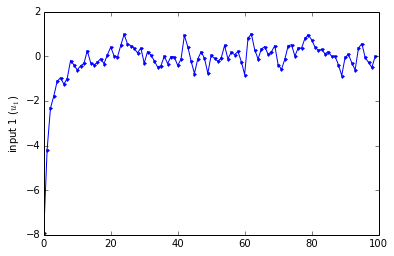

In [73]:
def riccati(A,B,Q,R,P):
    # optimal control is linear state feedback 
    K_ = np.dot( 1/(np.dot(B.T,np.dot(P,B)) + R), np.dot(B.T,np.dot(P,A)) )
    # optimal value is quadratic in state
    P_ = np.dot( (A - np.dot(B,K_)).T, np.dot(P, (A - np.dot(B,K_))) + np.dot(K_.T, np.dot(R, K_)) + Q )
    return K_,P_

n = 1
m = 1

def lqr(t,kappa=1,beta=1,q=1,r=1,Delta=1e-1):
    A = np.array([0.9])
    B = np.array([1])
    Q = np.array([1]) # running state cost
    R = np.array([1]) # running control cost

    K = np.zeros((t,m,n)) # linear state feedback gain matrix
    P = np.zeros((t+1,n,n)) # cost-to-go

    Pt = np.zeros((n,n)) # final state cost
    P[t] = Pt

    # loop over times
    for s in range(t)[::-1]: # loop backward in time
        K[s],P[s] = riccati(A,B,Q,R,P[s+1])
        
    return A,B,Q,R,K,P

t = 100

A,B,Q,R,K,P = lqr(t)

u1 = np.zeros((t,m,1))
x1 = np.zeros((t+1,n,1))
x1[0] = [[20]]
v1 = np.zeros((t))
for s in range(t):
    u1[s] = np.dot(-K[s],x1[s])
    x1[s+1] = np.dot(A,x1[s]) + np.dot(B, u1[s]) + np.random.normal(0, 1)
    v1[s] = 0.5 * np.dot( x1[s].T, np.dot(P[s], x1[s]))

plt.plot(u1[:,0,0],'.-')
plt.ylabel(r'input 1 ($u_1$)')

In [ ]:
u